#Connect to kaggle
upload kaggle.json first

In [1]:
! pip install kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json 
# Allocate the required permission for this file

#Downloading dataset from kaggle

In [5]:
! kaggle datasets download allandclive/chicken-disease-1

 97% 257M/266M [00:11<00:00, 16.7MB/s]
100% 266M/266M [00:11<00:00, 24.1MB/s]


In [6]:
! unzip chicken-disease-1.zip -d datasets/

Streaming output truncated to the last 5000 lines.
  inflating: datasets/Train/healthy.1867.jpg  
  inflating: datasets/Train/healthy.1868.jpg  
  inflating: datasets/Train/healthy.1869.jpg  
  inflating: datasets/Train/healthy.187.jpg  
  inflating: datasets/Train/healthy.1870.jpg  
  inflating: datasets/Train/healthy.1871.jpg  
  inflating: datasets/Train/healthy.1872.jpg  
  inflating: datasets/Train/healthy.1873.jpg  
  inflating: datasets/Train/healthy.1874.jpg  
  inflating: datasets/Train/healthy.1875.jpg  
  inflating: datasets/Train/healthy.1876.jpg  
  inflating: datasets/Train/healthy.1877.jpg  
  inflating: datasets/Train/healthy.1878.jpg  
  inflating: datasets/Train/healthy.1879.jpg  
  inflating: datasets/Train/healthy.188.jpg  
  inflating: datasets/Train/healthy.1880.jpg  
  inflating: datasets/Train/healthy.1881.jpg  
  inflating: datasets/Train/healthy.1882.jpg  
  inflating: datasets/Train/healthy.1883.jpg  
  inflating: datasets/Train/healthy.1884.jpg  
  inflating

# Import modules

In [7]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [8]:
sdir = r'/content/datasets/Train'
csvpath = r'/content/datasets/train_data.csv'
df = pd.read_csv(csvpath)
df.columns = ['filepaths', 'labels' ]
df['filepaths'] = df['filepaths'].apply(lambda x: os.path.join(sdir,x))
print(df.head())
# read dataset from csv and show it

                                filepaths              labels
0  /content/datasets/Train/salmo.1558.jpg          Salmonella
1  /content/datasets/Train/cocci.1866.jpg         Coccidiosis
2   /content/datasets/Train/cocci.171.jpg         Coccidiosis
3  /content/datasets/Train/salmo.1484.jpg          Salmonella
4     /content/datasets/Train/ncd.100.jpg  New Castle Disease


In [9]:
trsplit = .9
vsplit = .05
dsplit = vsplit/(1-trsplit)
strat = df['labels']
train_df, dummy_df = train_test_split(df, train_size=.9, shuffle=True, random_state=123, stratify=strat)
strat = dummy_df['labels']
test_df, valid_df = train_test_split(dummy_df, train_size=dsplit, shuffle=True, random_state=123, stratify=strat)
print('train_df lenght: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
# splitting dataset into train test valid

train_df lenght:  7260   test_df length:  403   valid_df length:  404


In [10]:
classes = list(train_df['labels'].unique())
class_count = len(classes)
groups = df.groupby('labels')
print('{0:^30s} {1:^13s}'.format('CLASS', 'IMAGE COUNT'))
for label in train_df['labels'].unique():
      group=groups.get_group(label)      
      print('{0:^30s} {1:^13s}'.format(label, str(len(group))))
# showing image count of every class in dataset

            CLASS               IMAGE COUNT 
         Coccidiosis               2476     
          Salmonella               2625     
           Healthy                 2404     
      New Castle Disease            562     


In [11]:
batch_size = 20 
trgen = ImageDataGenerator(horizontal_flip=True,
                           rotation_range=20, 
                           width_shift_range=0.2,
                           height_shift_range=0.2, 
                           zoom_range=0.2)
t_and_v_gen = ImageDataGenerator()
img_size=(224,224) #size of image
train_gen = trgen.flow_from_dataframe(train_df, 
                                      x_col='filepaths', 
                                      y_col='labels', 
                                      target_size=img_size,
                                      class_mode='categorical', 
                                      color_mode='rgb', 
                                      shuffle=True, 
                                      batch_size=batch_size)
valid_gen = t_and_v_gen.flow_from_dataframe(valid_df, 
                                            x_col='filepaths', 
                                            y_col='labels', 
                                            target_size=img_size,
                                            class_mode='categorical', 
                                            color_mode='rgb', 
                                            shuffle=False, 
                                            batch_size=batch_size)
# for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps=number of samples in test set
# this insures that we go through all the sample in the test set exactly once.
length = len(test_df)
test_batch_size = sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps = int(length/test_batch_size)
test_gen = t_and_v_gen.flow_from_dataframe(test_df, 
                                           x_col='filepaths', 
                                           y_col='labels', 
                                           target_size=img_size,
                                           class_mode='categorical', 
                                           color_mode='rgb', 
                                           shuffle=False, 
                                           batch_size=test_batch_size)
# from the generator we can get information we will need later
classes = list(train_gen.class_indices.keys())
class_indices = list(train_gen.class_indices.values())
class_count = len(classes)
labels = test_gen.labels
print('test batch size: ', test_batch_size,'  test steps: ', test_steps,' number of classes : ', class_count)
print('{0:^25s}{1:^12s}'.format('class name', 'class index'))
for klass, index in zip(classes, class_indices):
    print(f'{klass:^25s}{str(index):^12s}')

Found 7260 validated image filenames belonging to 4 classes.
Found 404 validated image filenames belonging to 4 classes.
Found 403 validated image filenames belonging to 4 classes.
test batch size:  31   test steps:  13  number of classes :  4
       class name        class index 
       Coccidiosis            0      
         Healthy              1      
   New Castle Disease         2      
       Salmonella             3      


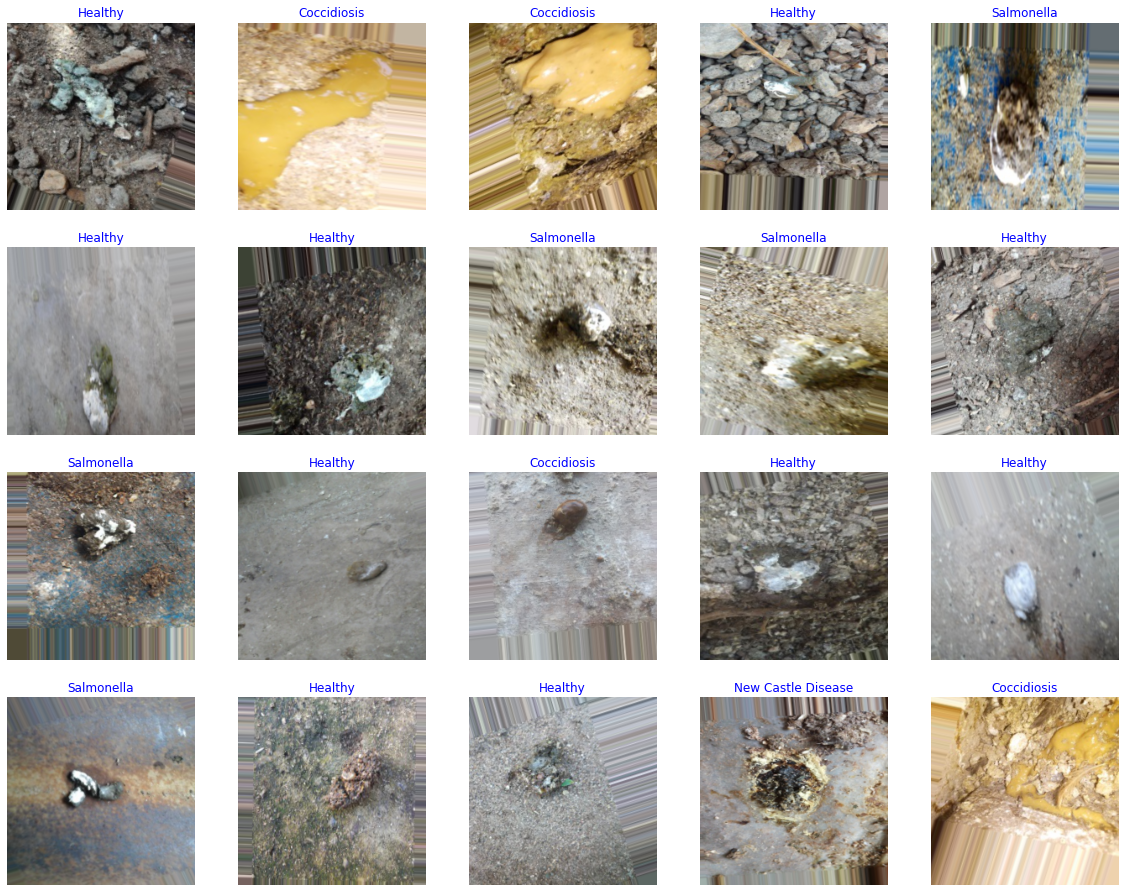

In [12]:
def show_image_samples(gen):
    t_dict = gen.class_indices
    classes = list(t_dict.keys())    
    images, labels = next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length = len(labels)
    if length<25:   #show maximum of 25 images
        r = length
    else:
        r = 25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image = images[i] /255       
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

##VGG16 

In [13]:
IMAGE_SIZE = [224, 224]

categories = ["Coccidiosis", "Healthy","Salmonella","New Castle Disease"]

In [14]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
# Menambahkan Layer untuk Preprocessing pada VGG16
vgg = VGG16(input_shape = IMAGE_SIZE + [3], 
            weights = 'imagenet',
            include_top=False)


# Untuk perintah menolak men training data yang telah digunakan sebelumnya
for layer in vgg.layers:
  layer.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [15]:
from keras.layers import Input, Lambda, Dense, Flatten
x = Flatten()(vgg.output)
x = Dense(1000, activation='relu')(x)

# Lapisan Terakhir dengan aktivasi softmax untuk output biner 
prediction = Dense(len(categories), activation='softmax')(x)

In [16]:
from keras.models import Model
# Membuat obbjek model 
model = Model(inputs=vgg.input, outputs=prediction)

# Melihat struktur model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [17]:
# tell the model what cost and optimization method to use
model.compile(
  loss='binary_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [18]:
# Mencocokan model
r = model.fit_generator(
  train_gen,
  validation_data=test_gen,
  epochs=50,
  steps_per_epoch=len(train_gen),
  validation_steps=len(test_gen)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/50
363/363 [==============================] - 156s 389ms/step - loss: 1.0294 - accuracy: 0.7697 - val_loss: 0.1937 - val_accuracy: 0.8561
Epoch 2/50
363/363 [==============================] - 123s 339ms/step - loss: 0.1974 - accuracy: 0.8365 - val_loss: 0.1357 - val_accuracy: 0.9032
Epoch 3/50
363/363 [==============================] - 123s 338ms/step - loss: 0.1702 - accuracy: 0.8616 - val_loss: 0.1232 - val_accuracy: 0.9132
Epoch 4/50
363/363 [==============================] - 122s 336ms/step - loss: 0.1607 - accuracy: 0.8748 - val_loss: 0.1239 - val_accuracy: 0.9057
Epoch 5/50
363/363 [==============================] - 122s 337ms/step - loss: 0.1529 - accuracy: 0.8775 - val_loss: 0.1472 - val_accuracy: 0.9007
Epoch 6/50
363/363 [==============================] - 125s 343ms/step - loss: 0.1479 - accuracy: 0.8828 - val_loss: 0.1075 - val_accuracy: 0.9107
Epoch 7/50
363/363 [==============================] - 122s 336ms/step - loss: 0.1440 - accuracy: 0.8860 - val_loss: 0.1272 -

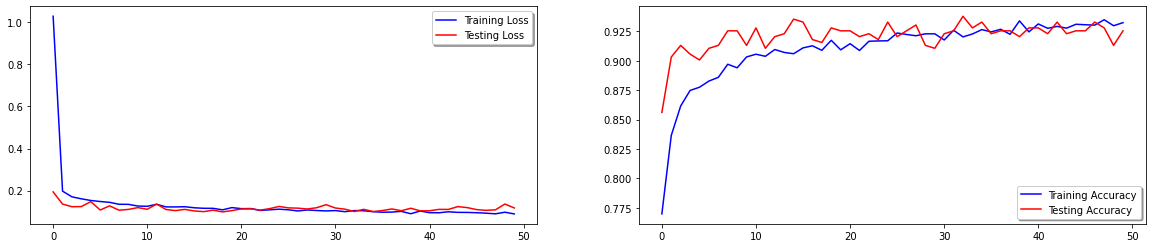

In [19]:
fig, ax = plt.subplots(figsize=(20, 4), nrows=1, ncols=2)

ax[0].plot(r.history['loss'], color='b', label="Training Loss")
ax[0].plot(r.history['val_loss'], color='r', label="Testing Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(r.history['accuracy'], color='b', label="Training Accuracy")
ax[1].plot(r.history['val_accuracy'], color='r',label="Testing Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
from sklearn.metrics import classification_report
ypred = model.predict(test_gen)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_gen.classes, prediction))

              precision    recall  f1-score   support

           0       0.95      0.92      0.93       124
           1       0.89      0.98      0.94       120
           2       0.81      0.61      0.69        28
           3       0.95      0.95      0.95       131

    accuracy                           0.93       403
   macro avg       0.90      0.86      0.88       403
weighted avg       0.92      0.93      0.92       403



In [21]:
# from keras.models import load_model

model.save('modelvgg16.h5')  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
# model = load_model('my_model.h5')